In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

In [2]:
features_num = [
    "Z_BEST", "z1_median", "u_f", "u_e", "u_e_raw", "Bw_f", "Bw_e", "Bw_e_raw", "R_f", "R_e", 
    "R_e_raw", "I_f", "I_e", "I_e_raw", "z_f", "z_e", "z_e_raw", "z_Subaru_f", "z_Subaru_e", 
    "z_Subaru_e_raw", "y_f", "y_e", "y_e_raw", "J_f", "J_e", "J_e_raw", "H_f", 
    "H_e", "H_e_raw", "K_f", "K_e", "K_e_raw", "Ks_f", "Ks_e", "Ks_e_raw", "ch1_f", "ch1_e", "ch1_e_raw", "ch2_f", 
    "ch2_e", "ch2_e_raw", "ch3_f", "ch3_e", "ch3_e_raw", "ch4_f", "ch4_e", "ch4_e_raw", "MIPS_24_f", 
    "MIPS_24_e", "MIPS_24_e_raw", "PACS_100_f", "PACS_100_e", "PACS_100_e_raw", "PACS_160_f", "PACS_160_e", 
    "PACS_160_e_raw", "SPIRE_250_f", "SPIRE_250_e", "SPIRE_250_e_raw", "SPIRE_350_f", "SPIRE_350_e", "SPIRE_350_e_raw", 
    "SPIRE_500_f", "SPIRE_500_e", "SPIRE_500_e_raw"

]
features_cat_binary = [
    "FLAG_OVERLAP", "XID+_rerun_mips", "XID+_rerun_pacs", "XID+_rerun_SPIRE", "CHANGE_FLAG_ID", 
    "CHANGE_FLAG_ZBEST", "CHANGE_FLAG_DEEP", "CHANGE_FLAG_FIR", "FLAG_GOOD"
]
features_cat_non_binary = [
    "FLAG_DEEP"
]
features_drop = [
    "Source_Name"
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [3]:
# Creating the pipeline
transformer_num = make_pipeline(
    SimpleImputer(strategy="mean"),  # there are a few missing values
    StandardScaler(),
)
# Almost all cat features are already binary, so don't have to be one-hot encoded
transformer_cat_binary = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
)
transformer_cat_non_binary = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse=False)
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat_binary, features_cat_binary),
    (transformer_cat_non_binary, features_cat_non_binary),
)

In [13]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/Bootes_clean.csv")

In [14]:
data = data.dropna()

In [36]:
data

,Source_Name,FLAG_DEEP,FLAG_OVERLAP,Z_BEST,z1_median,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE,CHANGE_FLAG_ID,CHANGE_FLAG_ZBEST,...,SPIRE_250_f,SPIRE_250_e,SPIRE_250_e_raw,SPIRE_350_f,SPIRE_350_e,SPIRE_350_e_raw,SPIRE_500_f,SPIRE_500_e,SPIRE_500_e_raw,Classification
13,ILTJ142430.68+352842.4,1,1,1.0140,1.0140,True,True,True,False,False,...,0.000359,0.000595,0.000594,0.000255,0.000394,0.000394,0.000267,0.000436,0.000435,jet-mode radio AGN/low-excitation radio galaxy
23,ILTJ142431.44+352124.0,1,1,0.2450,0.2867,True,True,True,False,False,...,0.008644,0.006108,0.006047,0.002512,0.002638,0.002626,0.000521,0.000793,0.000791,radio-quiet AGN
34,ILTJ142432.78+350753.4,1,1,2.8747,2.8747,True,True,True,False,False,...,0.000941,0.001232,0.001228,0.001201,0.001587,0.001582,0.000601,0.001019,0.001017,star-forming galaxy
35,ILTJ142433.10+345718.7,1,1,1.0419,1.0419,True,True,True,False,False,...,0.007250,0.005791,0.005746,0.004026,0.004043,0.004023,0.001004,0.001442,0.001439,star-forming galaxy
37,ILTJ142433.30+352630.2,1,1,0.4740,0.4321,True,True,True,False,False,...,0.009650,0.006646,0.006576,0.001231,0.001883,0.001879,0.000673,0.001088,0.001086,jet-mode radio AGN/low-excitation radio galaxy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17606,ILTJ143842.53+350028.5,2,1,0.9713,0.9713,True,True,True,False,False,...,0.003049,0.003507,0.003493,0.001392,0.002010,0.002005,0.001565,0.002239,0.002233,star-forming galaxy
17607,ILTJ143842.54+350048.2,1,1,6.7044,6.7044,False,False,False,False,False,...,0.012462,0.008328,0.008235,0.004204,0.004877,0.004859,0.001552,0.002292,0.002287,star-forming galaxy
17628,ILTJ143843.97+345954.8,1,1,0.5606,0.5606,False,False,False,False,False,...,0.002613,0.002851,0.002839,0.002721,0.003377,0.003366,0.004938,0.006039,0.006019,jet-mode radio AGN/low-excitation radio galaxy
17639,ILTJ143844.85+345936.6,1,1,0.8831,0.8831,False,False,False,False,False,...,0.023935,0.003607,0.002699,0.019824,0.004040,0.003520,0.015655,0.007467,0.007301,radio-quiet AGN


In [15]:
# Dropping required columns
X = data.drop(columns=features_drop)
X = X.drop(columns=y_column)
y = data[y_column]

In [16]:
# Transforming y to labels
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [17]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [18]:
# Class weights
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# PCA

In [19]:
pca = PCA().fit(X_train)

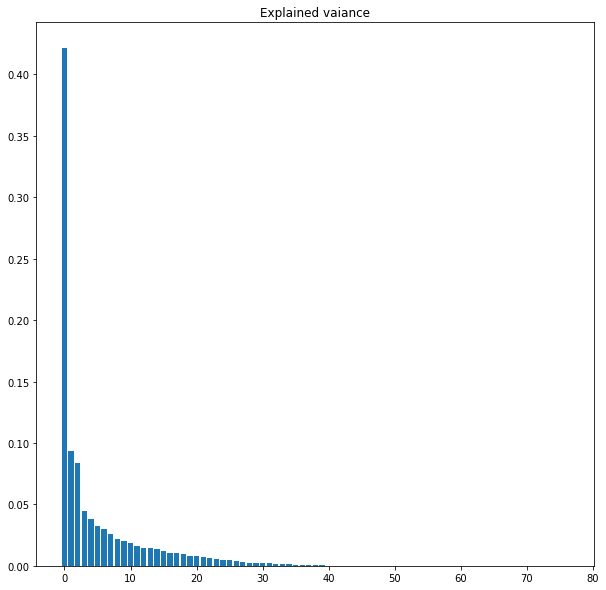

In [20]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance)
plt.title("Explained vaiance")
plt.show()

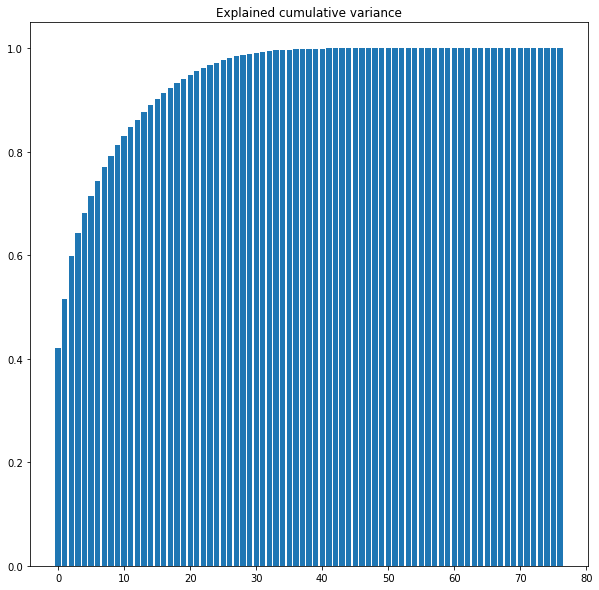

In [21]:
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance.cumsum())
plt.title("Explained cumulative variance")
plt.show()

# Random forest

In [22]:
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [23]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7750    0.4306    0.5536       288
quasar-like radio AGN / high-excitation radio galaxy     0.0000    0.0000    0.0000        41
                                     radio-quiet AGN     0.8393    0.4123    0.5529       228
                                 star-forming galaxy     0.8303    0.9792    0.8986      1584

                                            accuracy                         0.8262      2141
                                           macro avg     0.6111    0.4555    0.5013      2141
                                        weighted avg     0.8079    0.8262    0.7982      2141



[]

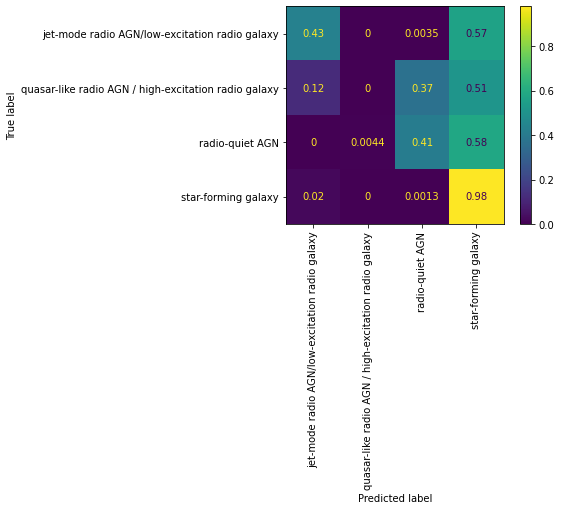

In [24]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [25]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['Importance'], ascending=False)

[]

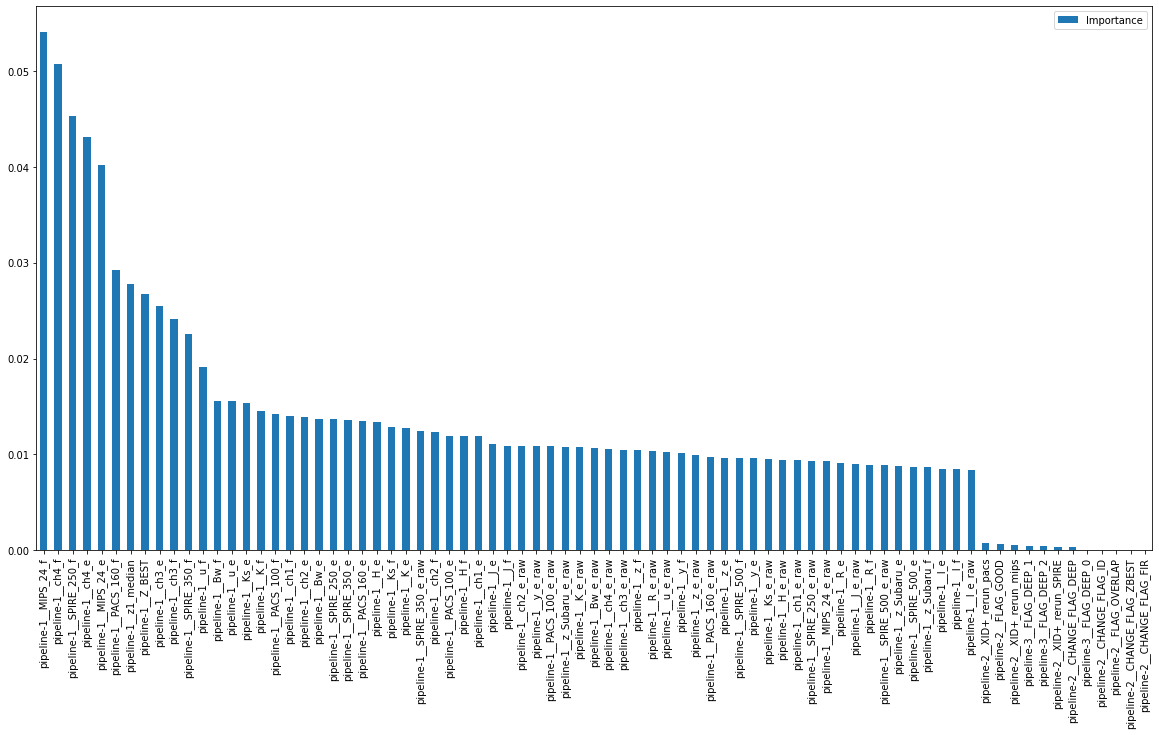

In [26]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)
plt.plot()

## Hyperparameter tuning

In [27]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [28]:
# Parameter space
parameters = {"n_estimators": [10,20,50,100,150,200],
             "criterion": ["gini", "entropy"],
             "max_depth": [10,30,50,70],
             "min_samples_split": [2,10,20],
             }

In [29]:
random_forest = RandomForestClassifier()
clf = GridSearchCV(estimator=random_forest, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=-1,
                  cv=2,
                  verbose=4)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


KeyboardInterrupt: 

In [ ]:
clf

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

# XGboost

In [30]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.04437
[1]	validation_0-mlogloss:0.85602
[2]	validation_0-mlogloss:0.73766
[3]	validation_0-mlogloss:0.65927
[4]	validation_0-mlogloss:0.60375
[5]	validation_0-mlogloss:0.56277
[6]	validation_0-mlogloss:0.53472
[7]	validation_0-mlogloss:0.51432
[8]	validation_0-mlogloss:0.49849
[9]	validation_0-mlogloss:0.48849
[10]	validation_0-mlogloss:0.48116
[11]	validation_0-mlogloss:0.47676
[12]	validation_0-mlogloss:0.47130
[13]	validation_0-mlogloss:0.46780
[14]	validation_0-mlogloss:0.46441
[15]	validation_0-mlogloss:0.46602
[16]	validation_0-mlogloss:0.46461
[17]	validation_0-mlogloss:0.46419
[18]	validation_0-mlogloss:0.46352
[19]	validation_0-mlogloss:0.46489
[20]	validation_0-mlogloss:0.46522
[21]	validation_0-mlogloss:0.46545
[22]	validation_0-mlogloss:0.46593
[23]	validation_0-mlogloss:0.46737
[24]	validation_0-mlogloss:0.46922
[25]	validation_0-mlogloss:0.47022
[26]	validation_0-mlogloss:0.47139
[27]	validation_0-mlogloss:0.47257
[28]	validation_0-mlogloss:0.4

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [31]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7366    0.5729    0.6445       288
quasar-like radio AGN / high-excitation radio galaxy     0.0000    0.0000    0.0000        41
                                     radio-quiet AGN     0.7733    0.5088    0.6138       228
                                 star-forming galaxy     0.8633    0.9609    0.9095      1584

                                            accuracy                         0.8421      2141
                                           macro avg     0.5933    0.5106    0.5419      2141
                                        weighted avg     0.8201    0.8421    0.8249      2141



[]

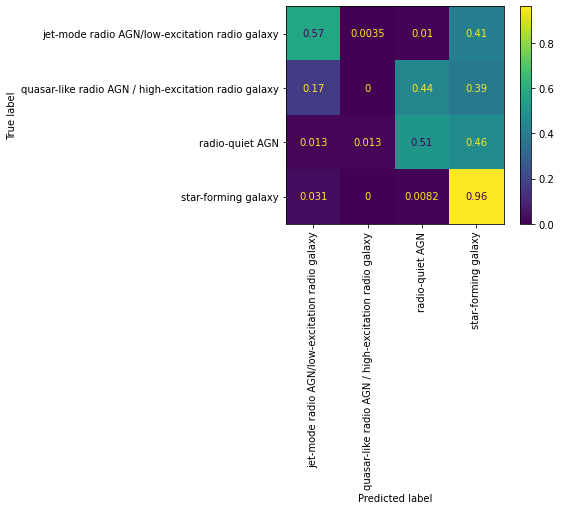

In [32]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# SVM

In [33]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [34]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7703    0.1979    0.3149       288
quasar-like radio AGN / high-excitation radio galaxy     0.0000    0.0000    0.0000        41
                                     radio-quiet AGN     0.8154    0.2325    0.3618       228
                                 star-forming galaxy     0.7847    0.9918    0.8762      1584

                                            accuracy                         0.7851      2141
                                           macro avg     0.5926    0.3555    0.3882      2141
                                        weighted avg     0.7710    0.7851    0.7291      2141



C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: Unde

[]

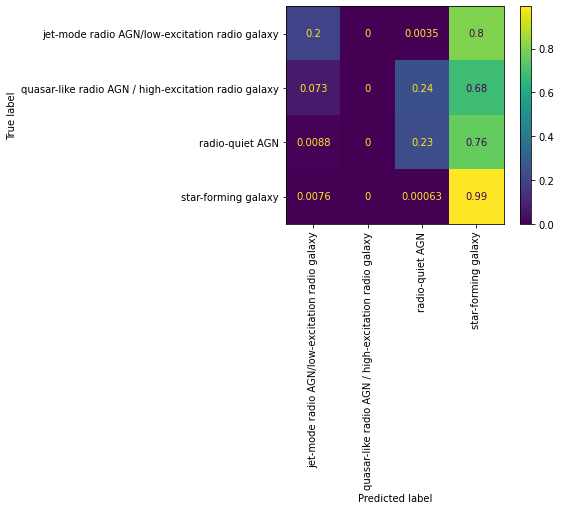

In [35]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()